## DX Expert 양성과정 WEEK 2
## Transformer - (2) 이미지 데이터 실습

## 강의 복습

강의자료 : Transformer, AGENDA 02 - Vision Transformer

## 실습 요약
1. 본 실습에서는 VisionTransfomer 기반의 이상치 탐지 모델인 AnoViT를 활용하여 이미지 이상탐지 모델을 구축합니다
2. 학습된 모델을 활용하여 평가를 진행합니다.
3. 해당 모델에 대한 전체적인 구조는 강의자료 AGENDA 02 106 page에서 확인하실 수 있습니다

---

### STEP 0. 환경 구축하기
* 필요한 library들을 import 합니다

In [1]:
import os
import sys
import time
import random
import copy
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.backends.cudnn as cudnn
from easydict import EasyDict
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
from AnoViT.model import Decoder_r
from AnoViT.funcs import EarlyStop
from AnoViT.dataloader import get_dataloader
from AnoViT.utils import time_string, convert_secs2time, AverageMeter, print_log
from AnoViT.timm.models.vision_transformer import *
from AnoViT.timm import create_model
from AnoViT.funcs import plt_show, denormalization
from AnoViT.mean_std import obj_stats_384

#check torch version & device
print ("Python version:[%s]."%(sys.version))
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device)) # device에 cuda:0가 프린트 된다면 GPU를 사용하는 상태입니다

Python version:[3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]].
PyTorch version:[2.5.0+cu121].
device:[cuda:0].


In [3]:
# set random seed 

def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)

### STEP 1. 데이터 준비하기

금일 실습에서는 **MVTecAD**데이터를 사용합니다. 
* 실제 산업 현장에서 발생가능한 결함들을 직접 생성하여 구축된 이미지 데이터
* 데이터셋 출처
  https://www.mvtec.com/company/research/datasets/mvtec-ad


* 해당 실습에서는 전체 15가지 카테고리 데이터 중 'grid'에 대한 카테고리에 대해 실험을 진행함
* 용량 문제로 인해 grid 데이터중에서도 100장의 이미지를 활용하여 모델링 수행


In [4]:
# 현재 데이터는 확인 용도

# normal 이미지 불러오기
img_path = './data/mvtec/mvtec/grid/test/good/000.png'
normal_img = Image.open(img_path)
#normal_img

In [5]:
# abnormal 이미지 불러오기
img_path = './data/mvtec/mvtec/grid/test/broken/000.png'
normal_img = Image.open(img_path)
#normal_img

### STEP 2. 학습 및 평가에 필요한 하이퍼파라미터 설정

In [6]:
args = EasyDict({
    'n_gpu':1,
    'image_size':384,
    'patch_size':16,
    'device':'cuda',
    'batch_size':8,
    'num_workers':16,
    'epochs':20,
    'lr':2e-4,
    'wd':1e-5,
    'obj':'grid',
    'val_ratio':0.4,
    'save_dir':'./AnoViT/result',
    'dataset_path':'./data/mvtec/mvtec',
    'model':'vit',
    'amp':True,
    'seed':42,
    'beta1':0.5,
    'beta2':0.999
})

In [7]:
device = args.device
if not os.path.exists(args.save_dir):
    os.makedirs(args.save_dir)

log = open('model_training_log_{}_{}.txt'.format(args.obj, args.model), 'w')
scaler = amp.GradScaler()

model = create_model('vit_base_patch16_384', pretrained=True)
decmodel = nn.Sequential(model, Decoder_r(args))
decmodel.to(device)

/tmp/ipykernel_3227743/1936513616.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Sequential(
  (0): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Bl

### STEP 3. Pytorch Dataset 정의하기

In [12]:
# 참고용 코드입니다. 해당 셀에서 실행하지 않습니다 

# def get_dataloader(args):
#     obj_mean, obj_std = obj_stats_384(args.obj)
#     trainT = T.Compose([T.Resize(args.image_size, Image.ANTIALIAS),
#                         T.ToTensor(),
#                         T.Normalize(mean=obj_mean,
#                                     std=obj_std)
#                                     ])

#     validT = T.Compose([T.Resize(args.image_size, Image.ANTIALIAS),
#                         T.ToTensor(),   
#                         T.Normalize(mean=obj_mean,
#                                     std=obj_std)
#                                     ])

#     testT = T.Compose([T.Resize(args.image_size, Image.ANTIALIAS),
#                         T.ToTensor(),
#                         T.Normalize(mean=obj_mean,
#                                     std=obj_std)
#                                     ])


#     train_dataset = MVTecDataset(args, args.dataset_path, class_name=args.obj, is_train=True, resize=args.image_size, transform_x=trainT)
#     valid_dataset = MVTecDataset(args, args.dataset_path, class_name=args.obj, is_train=True, resize=args.image_size, transform_x=validT)
#     img_nums = len(train_dataset)

#     indices = list(range(img_nums))
#     np.random.seed(args.seed)
#     np.random.shuffle(indices)
#     split = int(np.floor(args.val_ratio * img_nums))
#     train_idx, valid_idx = indices[split:], indices[:split]
#     train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
#     valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

#     test_dataset = MVTecDataset(args, args.dataset_path, class_name=args.obj, is_train=False, resize=args.image_size, transform_x=testT)


#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, sampler=train_sampler)
#     val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=args.batch_size, sampler=valid_sampler)
#     test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


#     return train_loader, val_loader, test_loader

In [13]:
train_loader, val_loader, _ = get_dataloader(args)

### STEP 4. 모델 학습 진행하기

In [14]:
optimizer = torch.optim.Adam(
        params=decmodel.parameters(),
        lr=args.lr,
        betas=(args.beta1, args.beta2))

In [15]:
def train(args, scaler, model, epoch, train_loader, optimizer, log):
    model.train()
    MSE = nn.MSELoss()

    for (x, _, _) in tqdm(train_loader):
        x = x.to(args.device)
        optimizer.zero_grad()
        if args.amp:
            with amp.autocast():
                x_hat = model(x)
                loss = MSE(x, x_hat)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

    print_log('Train Epoch: {} | MSE Loss: {:.6f}'.format(epoch, loss), log)


def val(args, model, epoch, val_loader, log):
    model.eval()
    MSE = nn.MSELoss()

    for (x, _, _) in tqdm(val_loader):
        x = x.to(args.device)
        with torch.no_grad():
            x_hat = model(x)
            loss = MSE(x, x_hat)
            
            if epoch % 10 == 0:
                plt_show(args, x_hat, x, epoch)


    print_log(('Valid Epoch: {} | MSE Loss: {:.6f}'.format(epoch, loss)), log)

    return loss, model

   1/ 20 ----- [[2024-10-25 09:57:11]] [Need: 00:00:00]


  0%|                                                                                                                                                                           | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_3221330/375961879.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


Train Epoch: 1 | MSE Loss: 1.231153


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


Valid Epoch: 1 | MSE Loss: 0.983492
   2/ 20 ----- [[2024-10-25 09:57:13]] [Need: 00:00:40]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]


Train Epoch: 2 | MSE Loss: 0.934725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


Valid Epoch: 2 | MSE Loss: 1.097081
   3/ 20 ----- [[2024-10-25 09:57:15]] [Need: 00:00:35]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.11it/s]


Train Epoch: 3 | MSE Loss: 0.863883


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


Valid Epoch: 3 | MSE Loss: 0.943124
   4/ 20 ----- [[2024-10-25 09:57:17]] [Need: 00:00:32]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Train Epoch: 4 | MSE Loss: 0.846322


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.70it/s]


Valid Epoch: 4 | MSE Loss: 1.147227
   5/ 20 ----- [[2024-10-25 09:57:19]] [Need: 00:00:30]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.92it/s]


Train Epoch: 5 | MSE Loss: 1.268243


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.58it/s]


Valid Epoch: 5 | MSE Loss: 1.060018
   6/ 20 ----- [[2024-10-25 09:57:21]] [Need: 00:00:28]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Train Epoch: 6 | MSE Loss: 0.886582


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.64it/s]


Valid Epoch: 6 | MSE Loss: 1.033304
   7/ 20 ----- [[2024-10-25 09:57:23]] [Need: 00:00:26]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.07it/s]


Train Epoch: 7 | MSE Loss: 0.773120


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


Valid Epoch: 7 | MSE Loss: 1.064730
   8/ 20 ----- [[2024-10-25 09:57:25]] [Need: 00:00:23]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.91it/s]


Train Epoch: 8 | MSE Loss: 0.943708


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.51it/s]


Valid Epoch: 8 | MSE Loss: 0.924301
   9/ 20 ----- [[2024-10-25 09:57:27]] [Need: 00:00:21]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.79it/s]


Train Epoch: 9 | MSE Loss: 1.012064


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.64it/s]


Valid Epoch: 9 | MSE Loss: 0.972582
  10/ 20 ----- [[2024-10-25 09:57:29]] [Need: 00:00:19]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.11it/s]


Train Epoch: 10 | MSE Loss: 0.919732


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Valid Epoch: 10 | MSE Loss: 0.855182
  11/ 20 ----- [[2024-10-25 09:57:31]] [Need: 00:00:18]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.07it/s]


Train Epoch: 11 | MSE Loss: 0.785018


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


Valid Epoch: 11 | MSE Loss: 0.764675
  12/ 20 ----- [[2024-10-25 09:57:33]] [Need: 00:00:16]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.05it/s]


Train Epoch: 12 | MSE Loss: 0.716464


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.67it/s]


Valid Epoch: 12 | MSE Loss: 0.789901
  13/ 20 ----- [[2024-10-25 09:57:35]] [Need: 00:00:14]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.14it/s]


Train Epoch: 13 | MSE Loss: 0.721575


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.64it/s]


Valid Epoch: 13 | MSE Loss: 0.794581
  14/ 20 ----- [[2024-10-25 09:57:37]] [Need: 00:00:12]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.88it/s]


Train Epoch: 14 | MSE Loss: 0.738029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.70it/s]


Valid Epoch: 14 | MSE Loss: 0.633858
  15/ 20 ----- [[2024-10-25 09:57:39]] [Need: 00:00:09]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Train Epoch: 15 | MSE Loss: 0.673157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


Valid Epoch: 15 | MSE Loss: 0.665360
  16/ 20 ----- [[2024-10-25 09:57:41]] [Need: 00:00:07]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.91it/s]


Train Epoch: 16 | MSE Loss: 0.565537


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


Valid Epoch: 16 | MSE Loss: 0.744511
  17/ 20 ----- [[2024-10-25 09:57:43]] [Need: 00:00:05]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.07it/s]


Train Epoch: 17 | MSE Loss: 0.794147


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.51it/s]


Valid Epoch: 17 | MSE Loss: 0.758316
  18/ 20 ----- [[2024-10-25 09:57:45]] [Need: 00:00:03]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.11it/s]


Train Epoch: 18 | MSE Loss: 0.490095


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


Valid Epoch: 18 | MSE Loss: 0.675024
  19/ 20 ----- [[2024-10-25 09:57:47]] [Need: 00:00:01]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.99it/s]


Train Epoch: 19 | MSE Loss: 0.618055


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.51it/s]


Valid Epoch: 19 | MSE Loss: 0.636900
  20/ 20 ----- [[2024-10-25 09:57:49]] [Need: 00:00:00]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.07it/s]


Train Epoch: 20 | MSE Loss: 0.594171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


Valid Epoch: 20 | MSE Loss: 0.619058


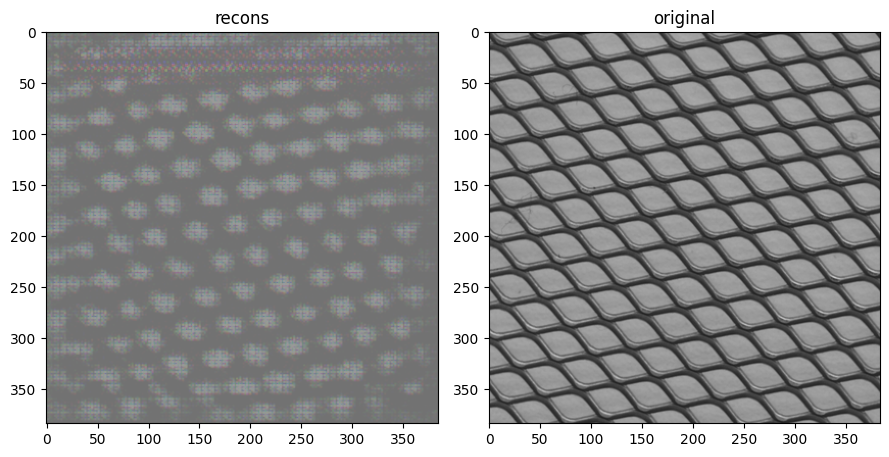

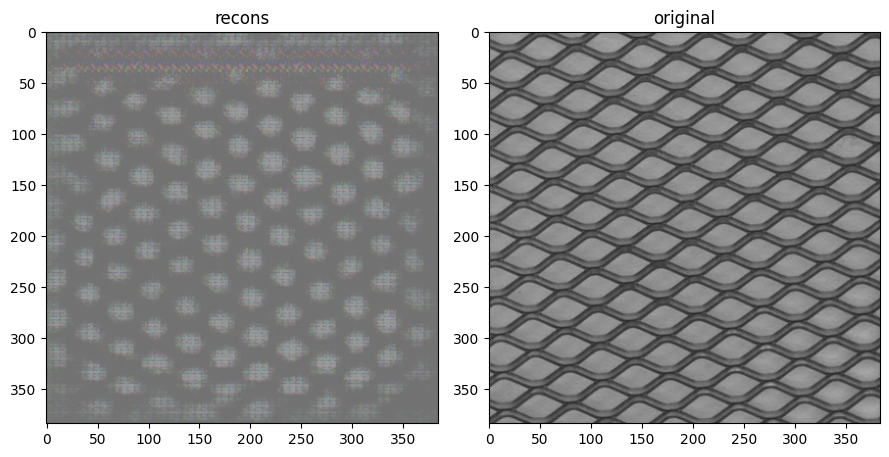

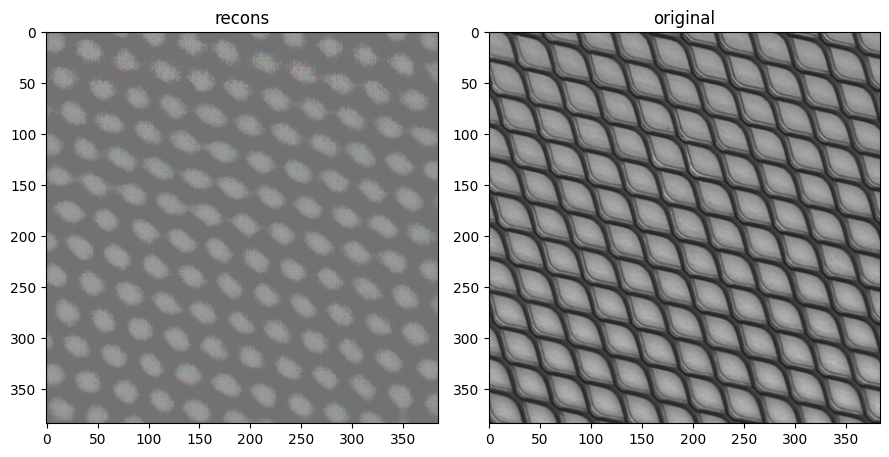

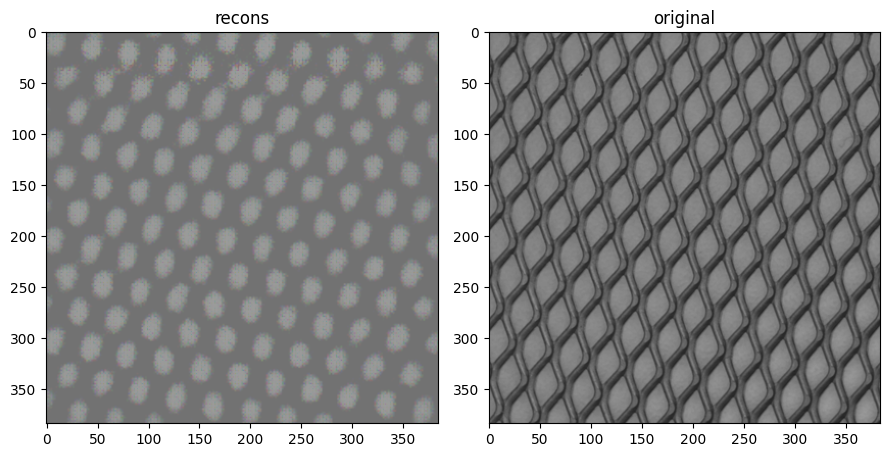

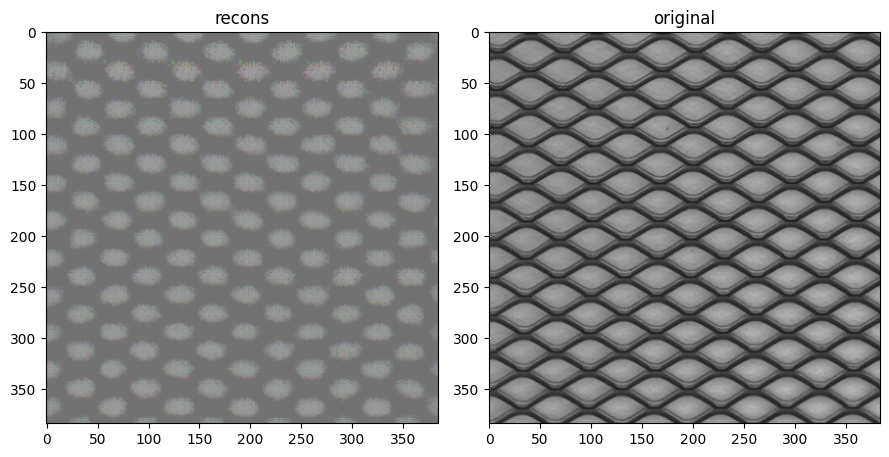

In [16]:
save_name = os.path.join(args.save_dir, 'model/{}_{}_best_model.pt'.format(args.obj, args.model))
early_stop = EarlyStop(patience=12, save_name=save_name)
start_time = time.time()
epoch_time = AverageMeter()
for epoch in range(1, args.epochs + 1):
    need_hour, need_mins, need_secs = convert_secs2time(epoch_time.avg * (args.epochs - epoch))
    need_time = '[Need: {:02d}:{:02d}:{:02d}]'.format(need_hour, need_mins, need_secs)
    print_log(' {:3d}/{:3d} ----- [{:s}] {:s}'.format(epoch, args.epochs, time_string(), need_time), log)
    
    
    train(args, scaler, decmodel, epoch, train_loader, optimizer, log)
    val_loss, save_model = val(args, decmodel, epoch, val_loader, log)


    epoch_time.update(time.time() - start_time)
    start_time = time.time()
log.close()

In [17]:
torch.save(save_model.state_dict(), 'AnoViT.pt')

### STEP 5. test 시 이상 이미지에 대한 score map 시각화

In [12]:
def save_test_image(test_loader, test_imgs, recon_imgs, mean, std, seg_scores, gt_mask_list):
    for num in range(len(test_loader)):
        # visualize the score map
        if num in [13, 62, 67, 71, 72, 73, 74, 75, 76, 77]:
            if test_imgs[num].dtype != "uint8":
                test_imgs[num] = denormalization(test_imgs[num], mean, std)

            if recon_imgs[num].dtype != "uint8":
                recon_imgs[num] = denormalization(recon_imgs[num], mean, std)

            scores_img = seg_scores[num]

            fig, plots = plt.subplots(1, 4)

            fig.set_figwidth(9)
            fig.set_tight_layout(True)
            plots = plots.reshape(-1)
            plots[0].imshow(test_imgs[num])
            plots[1].imshow(recon_imgs[num])
            plots[2].imshow(scores_img, cmap='jet', alpha=0.35)
            plots[3].imshow(gt_mask_list[num], cmap=plt.cm.gray)

            plots[0].set_title("real")
            plots[1].set_title("reconst")
            plots[2].set_title("anomaly score")
            plots[3].set_title("gt mask")

            plt.savefig('result/test_image/{}_{}_{}.png'.format(args.model, args.obj, num))


In [13]:
decmodel = nn.Sequential(model, Decoder_r(args))
decmodel.load_state_dict(torch.load('AnoViT.pt'), strict=False)
decmodel.to(device)
train_loader, valid_loader, test_loader = get_dataloader(args)

/tmp/ipykernel_3227743/2947171029.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decmodel.load_state_dict(torch.load('AnoViT.pt'), strict=False)


### STEP 6. Pixel AUROC에 대한 평가 진행

In [14]:
def test(model, test_loader, device=torch.device('cuda:0')):
    model.eval()
    MSE = nn.MSELoss(reduction='none')
    det_scores, seg_scores = [],[]
    test_imgs = []
    gt_list = []
    gt_mask_list = []
    recon_imgs = []

    det_sig, seg_sig = 15,6
    for (x, label, mask) in tqdm(test_loader):
        mask = mask.squeeze(0)
        test_imgs.extend(x.cpu().numpy())
        gt_list.extend(label.cpu().numpy())
        gt_mask_list.extend(mask.cpu().numpy())
        score = 0
        with torch.no_grad():
            x = x.to(device)
            x_hat = model(x)

            mse = MSE(x,x_hat)
            score = mse

        score = score.cpu().numpy()
        score = score.mean(1) #  channel간 평균

        det_score, seg_score = copy.deepcopy(score), copy.deepcopy(score)

        for i in range(det_score.shape[0]):
            det_score[i] = gaussian_filter(det_score[i], sigma=det_sig)
        det_scores.extend(det_score)

        for i in range(seg_score.shape[0]):
            seg_score[i] = gaussian_filter(seg_score[i], sigma=seg_sig)
        seg_scores.extend(seg_score)

        recon_imgs.extend(x_hat.cpu().numpy())
    return det_scores, seg_scores, test_imgs, recon_imgs, gt_list, gt_mask_list

In [15]:
det_scores, seg_scores, test_imgs, recon_imgs, gt_list, gt_mask_list = test(decmodel, test_loader, device)

# det_scores = np.asarray(det_scores)
# max_anomaly_score = det_scores.max()
# min_anomaly_score = det_scores.min()
# det_scores = (det_scores - min_anomaly_score) / (max_anomaly_score - min_anomaly_score)

seg_scores = np.asarray(seg_scores)
max_anomaly_score = seg_scores.max()
min_anomaly_score = seg_scores.min()
seg_scores = (seg_scores - min_anomaly_score) / (max_anomaly_score - min_anomaly_score)

gt_mask = np.asarray(gt_mask_list)
gt_mask = gt_mask.astype('int')
per_pixel_rocauc = roc_auc_score(gt_mask.flatten(), seg_scores.flatten())
print('pixel ROCAUC: %.2f' % (per_pixel_rocauc))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 34.17it/s]


pixel ROCAUC: 0.82
